**revised for final release**

This notebook is the second of 2 parts for the analysis of human data presented in Supplemental Figure 7. This notebook ingests the location of nucleosomes (from DANPOS dpos, filtered and converted by `danpos-xls-process.py`), the nucleosome positioning track (from DANPOS dpos, pre-processed by the somewhat misnamed `wig2rle.R`), and PF binding sites (processed from FIMO results via [`py3_motif-matching-human-public.ipynb`](py3_motif-matching-human-public.ipynb)), and outputs the final figures (though the file-writing cells have been disabled).

**Warning** - this notebook requires significant computational resources and was originally run on a compute node of the Rockefeller High-Performance Computing environment. You should have at least 10 GB of RAM available to the R kernel (not just on the machine, as other programs will require their own memory) - most laptops will not have this much memory. I have observed my notebooks' memory usage peaking at as much as 80 GB of RAM (!).

I suspect that the main culprit is the `strandedDistanceByNearest` call. I welcome suggestions to improve its decidedly inefficient iterative algorithmic structure, which was regrettably necessary to handle NAs.

## various initialization steps

In [16]:
# for my sanity - map some function names that I think exist to what actually exist
nrows <- nrow
ncols <- ncol
len <- length

In [1]:
library(repr)
options(repr.plot.width=6, repr.plot.height=3)
library(ggplot2)
options(warn=-1)

In [2]:
library(tracktables)
library(rtracklayer)
library(GenomicFeatures)
library(BSgenome.Hsapiens.UCSC.hg38)
library(grid)
library(heatmaps)

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, w

In [3]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  # from Winston Chang's R Cookbook

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [4]:
# get seqinfo (but also since the BSgenome is from UCSC, remap coordinates back to NCBI/ensembl)

hg38info <- keepStandardChromosomes(seqinfo(BSgenome.Hsapiens.UCSC.hg38), pruning.mode = "tidy")
newStyle <- mapSeqlevels(seqlevels(hg38info),"NCBI")
hg38info <- (renameSeqlevels(hg38info, newStyle))
hg38info

Seqinfo object with 25 sequences (1 circular) from hg38 genome:
  seqnames seqlengths isCircular genome
  1         248956422      FALSE   hg38
  2         242193529      FALSE   hg38
  3         198295559      FALSE   hg38
  4         190214555      FALSE   hg38
  5         181538259      FALSE   hg38
  ...             ...        ...    ...
  21         46709983      FALSE   hg38
  22         50818468      FALSE   hg38
  X         156040895      FALSE   hg38
  Y          57227415      FALSE   hg38
  MT            16569       TRUE   hg38

## load motif locations into bioconductor

general formula: genomic coordinate of a motif's start = genomic coordinate of a motif's peak window + FIMO-reported start coordinate - value of flanking DNA bp (generally 200) - 1 (due to 1-based indexing, likely in FIMO)

In [5]:
std_Octmotifs   <- import("~/SoxOct/chipseq/Soufi2012/Oct_motifs_200.strand.bed")
std_Oct28motifs <- import("~/SoxOct/chipseq/Soufi2012/Oct28_motifs_200.strand.bed")
std_Oct42motifs <- import("~/SoxOct/chipseq/Soufi2012/Oct42_motifs_200.strand.bed")

std_Octmotifs_c   <- resize(std_Octmotifs  , width = 2, fix = 'center')
std_Oct28motifs_c <- resize(std_Oct28motifs, width = 2, fix = 'center')
std_Oct42motifs_c <- resize(std_Oct42motifs, width = 2, fix = 'center')

std_Soxmotifs   <- import("~/SoxOct/chipseq/Soufi2012/Sox_motifs_200.strand.bed")
std_Sox74motifs <- import("~/SoxOct/chipseq/Soufi2012/Sox74_motifs_200.strand.bed")

std_Soxmotifs_c   <- resize(std_Soxmotifs  , width = 2, fix = 'center')
std_Sox74motifs_c <- resize(std_Sox74motifs, width = 2, fix = 'center')

std_outermotifs <- import("~/SoxOct/chipseq/Soufi2012/tandem_motifs_200.strand.bed")
std_outermotifs_c <- resize(std_outermotifs, width = 2, fix = 'center')

## load nucleosome positions

In [6]:
npeaks_h_p <- import("~/SoxOct/danpos-res/pooled/hESC-MNaseseq.smooth.positions.bedgraph")

# resize the nucleosome peaks (DANPOS hard-codes them to be 140 bp)
npeaks_h_p_c <- resize(npeaks_h_p, width = 2, fix = "center")

## define colors for graphing

In [7]:
safered <- "#920000"
safegreen <- "#009292"
safeviolet <- "#490092"

## stranding

In [8]:
strandedDistanceByNearest <- function(query, target){
    # gets (non absolute) distance for each item in query on target
    
    # calculate the distance:
    
    ## note that precede actually returns the item in subject that the target PRECEDES, not the other way around!
    #d_precede <- distance((target)[precede(subject = target, x = query)], query)
    ## you'd think the above would work, but annoyingly sometimes you get an NA, and then the subsetting dies...
    idx_precede <- precede(subject = target, x = query)
    d_precede <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_precede[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- distance(target[index],query[i])
        }
        
        d_precede[i] <- assign
    }
    
    ## the same goes for follow; the negation is so we correctly have negative distances
    #d_follow  <- -distance((target)[follow(subject = target, x = query)], query)
    
    idx_follow <- follow(subject = target, x = query)
    d_follow <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_follow[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- -distance(target[index],query[i]) # note that here is the negation!
        }
        
        d_follow[i] <- assign
    }
    
    # compare precede vs. follow
    # return the one with the biggest abs
    # if one of them is null, the other wins by default; if both are null, return NA
    # note that this is tremendously inelegant and likely to be slow!!!
    
    answer <- integer(length(query)) # pre-allocate a vector to make this less bad
    for (i in 1:length(query)){
        
        
        if (is.na(d_precede[i]) & !is.na(d_follow[i])){
        # only the follow number is valid
            select <- d_follow[i]
        } else if (!is.na(d_precede[i]) & is.na(d_follow[i])){
        # only the precede is valid
            select <- d_precede[i]
        } else if (is.na(d_precede[i]) & is.na(d_follow[i])){
        # somehow both are invalid??
            select <- NA
        } else {
        # both are presumably valid now
            if (abs(d_follow[i]) < d_precede[i]) {
                select <- d_follow[i]
            } else select <- d_precede[i]
            
        }
        answer[i] <- select
    }
    
    return (answer)
}

In [9]:
strandeddens <- function(data, filter = 150, bw = 2, color="orchid4",linetype="solid"){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    plt <- ggplot() +
            #geom_histogram(aes(y=..density..), binwidth=1, fill = 'gray') +
            stat_density(data = df, aes(x=x), bw=bw, color = color, geom = 'line', linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            geom_vline(xintercept=-73, linetype='dotted') + 
            geom_vline(xintercept=0, linetype='dashed')   +
            coord_cartesian(ylim = c(0,.007)) + 
            xlab("Relative distance (bp)") +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.8)))

    plt 
    
    return (plt)
}

In [11]:
unstrandeddens <- function(data, filter = 150, bw = 2, color = "orchid4", linetype="solid",
                            smoothleft=FALSE, smoothright=FALSE){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    # take the absolute value
    df <- abs(df)
    df <- rbind(df, data.frame(x=df[df$x ==0,])) # pads the zero position X2 
                                # since it should be doubled to match everything else
    if (smoothleft) {
        nzeros <- mean(
                        c(
                          len(df[df$x==0,]),
                          len(df[df$x==1,]),
                          len(df[df$x==2,]),
                          len(df[df$x==3,]),
                          len(df[df$x==4,]),
                          len(df[df$x==5,]),
                          len(df[df$x==6,])))
        #

        pad_df <- data.frame(x=c(rep(-1,nzeros), 
                             rep(-2,nzeros),
                             rep(-3,nzeros),
                             rep(-4,nzeros),
                             rep(-5,nzeros),
                             rep(-6,nzeros),
                             rep(-7,nzeros),
                             rep(-8,nzeros),
                             rep(-9,nzeros)))
    
        df  <- rbind(df, pad_df)   # pad to avoid the blip down at zero
    }
    
    if (smoothright){
        nends <- mean(
                        c(
                          len(df[df$x==filter  ,]),
                          len(df[df$x==filter-1,]),
                          len(df[df$x==filter-2,]),
                          len(df[df$x==filter-3,]),
                          len(df[df$x==filter-4,]),
                          len(df[df$x==filter-5,]),
                          len(df[df$x==filter-6,])))

        #nends <- len(df[df$x==filter,]) # 
        pad_df <- data.frame(x=c(rep(filter+1,nends), 
                             rep(filter+2,nends),
                             rep(filter+3,nends),
                             rep(filter+4,nends),
                             rep(filter+5,nends),
                             rep(filter+6,nends),
                             rep(filter+7,nends),
                             rep(filter+8,nends),
                             rep(filter+9,nends)))
        df  <- rbind(df, pad_df)   # pad to avoid the blip down at other side
    }

    smoothdens <- density(df$x, bw=bw)
    
    smoothdata <- data.frame(x=smoothdens$x, y=smoothdens$y)
    
    plt <- ggplot(data=smoothdata) +
            geom_line(aes(x=x, y=y), color = color,  
                         linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            ##geom_vline(xintercept=-73, linetype='dotted') +
            #geom_vline(xintercept=31, linetype='dotted')  +
            #geom_vline(xintercept=36, linetype='dotted')  +
            #geom_vline(xintercept=40, linetype='dotted')  +
            #geom_vline(xintercept=64, linetype='dotted')  +
            xlim(c(0,filter)) +
            coord_cartesian(ylim = c(0,.012),
                            xlim = c(0, filter)) + 
            xlab("Distance from dyad (bp)") +
            ylab("Density") +
            geom_vline(xintercept=0, linetype='dashed') +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.75))) + 
            theme(text = element_text(family = 'Arial'))

    plt 
    
    return (plt)
}

## supplemental figure 7 (calculate distances)

**warning** - this step is very slow!

In [12]:
dist_strand_h_p_Sox    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Soxmotifs_c)
dist_strand_h_p_Oct    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Octmotifs_c)

In [13]:
dist_strand_h_p_Oct28    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Oct28motifs_c)
dist_strand_h_p_Oct42    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Oct42motifs_c)
dist_strand_h_p_Sox74    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Sox74motifs_c)

In [19]:
plt_Sox <-   unstrandeddens(dist_strand_h_p_Sox,   filter = 150, bw=3,
                             smoothleft=TRUE, smoothright=TRUE, color=safered)      +ggtitle('hESC Sox2')    
plt_Oct <-   unstrandeddens(dist_strand_h_p_Oct,   filter = 150, bw=3,
                             smoothleft=TRUE, smoothright=TRUE, color=safegreen)    +ggtitle('hESC Oct4')    

plt_Oct28 <- unstrandeddens(dist_strand_h_p_Oct28, filter = 150, bw=3,
                             smoothleft=TRUE, smoothright=TRUE, color=safegreen, linetype="31") +ggtitle('Oct4 variant I')
plt_Oct42 <- unstrandeddens(dist_strand_h_p_Oct42, filter = 150, bw=3,
                             smoothleft=TRUE, smoothright=TRUE, color=safegreen, linetype="31") +ggtitle('Oct4 variant II') 
plt_Sox74 <- unstrandeddens(dist_strand_h_p_Sox74, filter = 150, bw=3,
                              smoothleft=TRUE, smoothright=TRUE, color=safered, linetype="31")   +ggtitle('noncanonical Sox2') 


blankplt <- ggplot()

### final figure

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


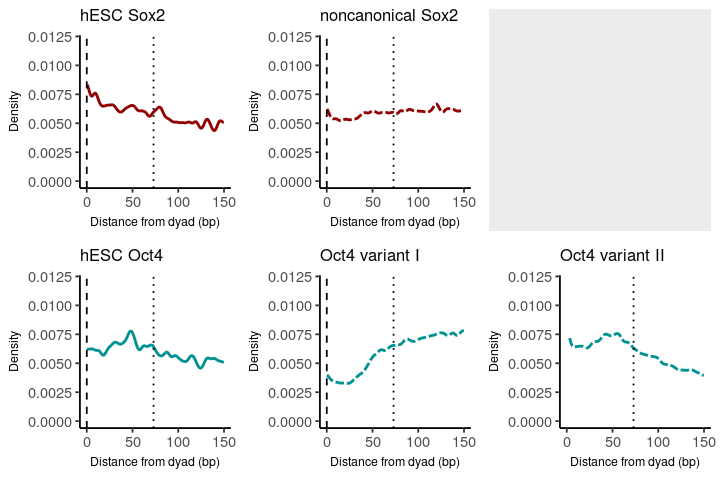

In [20]:
options(repr.plot.width=6, repr.plot.height=4)
multiplot(  plt_Sox,
          plt_Sox74,
          blankplt,
            plt_Oct,
          plt_Oct28,
          plt_Oct42 +xlim(3,150),
          layout=matrix(c(1,2,3,4,5,6), nrow=2, byrow=TRUE))
options(repr.plot.width=6, repr.plot.height=2)

## Stats

### helper functions

In [21]:
# helper

mass <- function(dist, filter){
    # takes a raw vector -- i.e. a raw dataset of distances -- and converts it to a freq table
    df = data.frame(x=dist)
    df = df[abs(df$x) <= filter,]
    
    return (as.data.frame(table(df), stringsAsFactors = FALSE))
}

moment  <- function(dist, filter, order=1){
    
    item <- mass(dist,filter)
    return ((item$Freq %*% (as.numeric(item$df)^order)) / sum(item$Freq))
}

filterData <- function(dataset, minbound, maxbound){
    
    filter <- max(abs(minbound),abs(maxbound))
    
    counts <- mass(dataset, filter=filter)
    
    retval <- counts[as.numeric(counts$df) >= minbound & as.numeric(counts$df) <= maxbound,]
    return (retval)
}

In [22]:
t_test_wrap_unstrand <- function(dataset, window=13){

    #res <- t.test(filterData(dataset, minbound = 0, maxbound = (window-1))$Freq, 
    #               filterData(dataset, minbound = 36-floor((window-1)/2), 
    #                          maxbound = 36+ceiling((window-1)/2))$Freq)$p.value
    #print(c("1/4 vs. dyad:", res))
    #
    #res <- t.test(filterData(dataset, minbound =  73 - (window-1), maxbound = 73)$Freq, 
    #               filterData(dataset, minbound = 36-floor((window-1)/2), 
    #                          maxbound = 36+ceiling((window-1)/2))$Freq)$p.value
    #print(c("1/4 vs. edge:", res))
    
    res <- t.test(filterData(dataset, minbound =  73 - (window-1), maxbound = 73)$Freq, 
                   filterData(dataset, minbound = 0, maxbound = (window-1))$Freq)$p.value
    print(c("dyad vs. edge:", res))
}

In [23]:
unstrand <- function(data, filter = 150){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    # take the absolute value
    df <- abs(df)
    df <- rbind(df, data.frame(x=df[df$x ==0,]))
    
    return (df)
}

In [25]:
window=13

print("Sox")
t_test_wrap_unstrand(unstrand(dist_strand_h_p_Sox), window=window)
print("Oct")
t_test_wrap_unstrand(unstrand(dist_strand_h_p_Oct), window=window)

print("noncanonical Sox")
t_test_wrap_unstrand(unstrand(dist_strand_h_p_Sox74), window=window)
print("noncanonical Oct42")
t_test_wrap_unstrand(unstrand(dist_strand_h_p_Oct42), window=window)
print("noncanonical Oct28")
t_test_wrap_unstrand(unstrand(dist_strand_h_p_Oct28), window=window)

[1] "Sox"
[1] "dyad vs. edge:"      "0.00983497761689007"
[1] "Oct"
[1] "dyad vs. edge:"    "0.391982492301896"
[1] "noncanonical Sox"
[1] "dyad vs. edge:"    "0.660171430571145"
[1] "noncanonical Oct42"
[1] "dyad vs. edge:"    "0.505817652422867"
[1] "noncanonical Oct28"
[1] "dyad vs. edge:"      "4.0211559457006e-08"


In [26]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.2 (Maipo)

Matrix products: default
BLAS/LAPACK: /rugpfs/fs0/zhao_lab/scratch/ezheng/.store/.miniconda3/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] heatmaps_1.6.0                    BSgenome.Hsapiens.UCSC.hg38_1.4.1
 [3] BSgenome_1.50.0                   Biostrings_2.50.2                
 [5] XVector_0.22.0                    GenomicFeatures_1.34.6           
 [7] AnnotationDbi_1.44.0              Biobase_2.42.0                   
 [9] rtracklayer_1.42.2                GenomicRanges_1.34.0             
[11] GenomeInfoDb_1.18.2               IRanges_2.16.0                   
[13] S4Vectors_0.20.1                  BiocGenerics_0.28.0              
[15] tracktables_1.16.0                ggplot2_3.1.1